In [73]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pandas as pd
from scipy.io import savemat, loadmat
import os
from tqdm import notebook
import numpy as np

from sklearn.model_selection import GridSearchCV
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

from sklearn.feature_selection import RFE
from joblib import dump, load
from sklearn.decomposition import PCA

from scipy.stats import entropy
import matplotlib
from matplotlib.gridspec import GridSpec
from xgboost import cv
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle as pkl
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle as pkl

from sklearn.model_selection import cross_val_predict
import itertools

import shap
from shap.plots import colors
shap.initjs()

# Load data

Here we load the data that we prepared in MATLAB

In [2]:
version = 'v11'
window = 21
data = loadmat(f'./data/age_model_data_{window}_days_{version}.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X_all', 'd_all', 'e_all', 'g_all', 'iqr_all', 'med_all', 'n_all', 'p_all', 't_all', 'td_all', 'u_all', 'y_all'])

In [3]:
x_jid = np.squeeze(data['X_all'])
y_age = np.squeeze(data['y_all'])
x_gender = np.squeeze(data['g_all'])
x_usage = np.squeeze(data['u_all'])
x_entropy = np.squeeze(data['e_all'])
x_median = np.squeeze(data['med_all'])
x_iqr = np.squeeze(data['iqr_all'])
z_days = np.squeeze(data['d_all'])
z_total_days = np.squeeze(data['td_all'])
partIds = np.array([a[0] for a in np.squeeze(data['p_all'])])

print(x_jid.shape, len(set(partIds)))

(5235, 2500) 808


In [4]:
# Filter the samples where the JID are computed using less than 10 days, as this is usually a very noisy JID, the threshold can be changed
threshold_days = 10
idxs = z_days>= threshold_days
x_jid = x_jid[idxs]
y_age = y_age[idxs]
x_gender = x_gender[idxs]
x_median = x_median[idxs]
x_iqr = x_iqr[idxs]
x_usage = x_usage[idxs]
x_entropy = x_entropy[idxs]
# x_screen_size = x_screen_size[idxs]
partIds = partIds[idxs]
z_total_days = z_total_days[idxs]
z_days = z_days[idxs]
print(x_jid.shape)

(5093, 2500)


In [ ]:
# filter age
idxs = y_age >= 40
x_jid = x_jid[idxs]
y_age = y_age[idxs]
x_gender = x_gender[idxs]
x_median = x_median[idxs]
x_iqr = x_iqr[idxs]
x_usage = x_usage[idxs]
x_entropy = x_entropy[idxs]
# x_screen_size = x_screen_size[idxs]
partIds = partIds[idxs]
z_total_days = z_total_days[idxs]
z_days = z_days[idxs]
print(x_jid.shape)

In [5]:
# create the X, Y matrices for model training
X = np.concatenate([x_jid,
                    y_age[:, None],
                    np.log10(x_iqr[:, None]),
                    np.log10(x_median[:, None]),
                    np.log10(x_usage[:, None]),
                    partIds[:, None]
                    ], axis=1)
Y = y_age
print(X.shape, Y.shape)

(5093, 2505) (5093,)


We first do some feature selection, this is not necessary all the times, but it is good practice. We want to reduce the space from 2504 features to 250 to reduce overfitting. The parameters of the simple model to do the feature selection are set in a naive way as this is not the final model.

In [ ]:
rfe = RFE(xgb.XGBRegressor(tree_method='gpu_hist'), verbose=1, step=1, n_features_to_select=250)
rfe.fit(X, Y)

In [ ]:
# Saving
pkl.dump({'support': rfe.support_}, open(f"./params/params_age_{version}.pkl", "wb"))

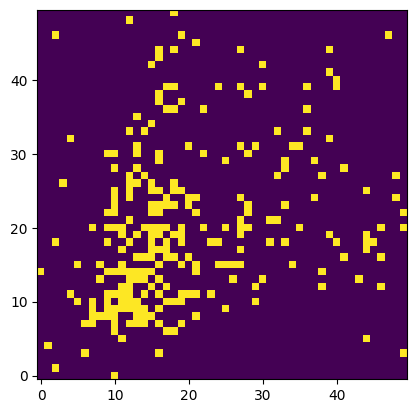

In [6]:
# Retrieving the parameters
param_dict = pkl.load(open(f"./params/params_age_20_days_v8.pkl", "rb"))

plt.imshow(param_dict['support'][:2500].reshape(50, 50))
plt.gca().invert_yaxis()

To do a proper cross validation we need to make sure samples from the same subjects do not go to both train and test.
So we first need to select the subjects for each fold and the assign the sample.

In [7]:
np.random.seed(41)
n_subs = len(set(partIds))
set_partIds = np.array(list(set(partIds)))
_idx = np.random.permutation(n_subs)
permuted_partIds = set_partIds[_idx]
n_folds = 10
folds = []
idxs = np.arange(len(X))
for f in np.array_split(permuted_partIds, n_folds):
    _idxs_test = idxs[np.array([a in f for a in partIds])]
    _idxs_train = idxs[np.array([a not in f for a in partIds])]
    folds.append((_idxs_train, _idxs_test))
print(sum([sum(a) + sum(b) for a, b in folds])/ 10000)
# 12966.778 - full

12966.778


In [8]:
for (_a, _b) in folds:
    print(f"{len(_a)} | {len(_b)}")

4610 | 483
4641 | 452
4436 | 657
4612 | 481
4608 | 485
4571 | 522
4550 | 543
4558 | 535
4609 | 484
4642 | 451


In [9]:
feat_names = [f"{i // 50}-{i % 50}" for i in range(2500) ] + ['age', 'iqr_iti', 'median_iti', 'median_taps', 'participationId']

X = pd.DataFrame(X, columns=feat_names)
X.head()

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,0-9,...,49-45,49-46,49-47,49-48,49-49,age,iqr_iti,median_iti,median_taps,participationId
0,-11.502199869718812,-3.0285808478965888,-2.727550852962291,-2.426520857663154,-2.7275508529622927,-2.329610844728064,-3.0285808478965888,-2.5514595941498395,-11.502199869718812,-2.551459594149841,...,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,59.03681292781381,3.4056877866727775,2.9777236052888476,4.092158996391268,138ee6d165fa06954ba1bed56719415b12dd28eb
1,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,...,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,59.201030377807086,3.0856472882968564,2.7708520116421442,3.5949999167322457,138ee6d165fa06954ba1bed56719415b12dd28eb
2,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,...,-11.502199869718812,-2.6610355585454184,-11.502199869718812,-11.502199869718812,-11.502199869718812,59.365218290378614,3.1166077439882485,2.9116901587538613,3.7255849722706946,138ee6d165fa06954ba1bed56719415b12dd28eb
3,-11.502199869718812,-11.502199869718812,-11.502199869718812,-2.9795843355006184,-11.502199869718812,-2.979584335500617,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,...,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,59.529424037086976,3.1112625136590655,2.9036325160842376,3.9648722086377752,138ee6d165fa06954ba1bed56719415b12dd28eb
4,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,...,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,-11.502199869718812,59.69390803490781,3.1878026387184195,2.965201701025912,3.7623033632877685,138ee6d165fa06954ba1bed56719415b12dd28eb


In [10]:
# This full test is used from cross validation
nbins = 50
_feat_selection = [f"{i // nbins}-{i % nbins}" for (i, v) in enumerate(param_dict['support'][:-4]) if v ] + ['iqr_iti', 'median_iti', 'median_taps']

Xdf = X[_feat_selection].astype('float32')
Ydf = X['age'].astype('float32')

dM = xgb.DMatrix(data=Xdf, label=Ydf)

_X = dM.get_data()
_y = dM.get_label()

print(_X.shape, _y.shape)

(5093, 250) (5093,)


In [11]:
params = {'objective':'reg:squarederror', 
          'tree_method': 'gpu_hist',
          'learning_rate': 0.1, 
          'max_depth': 4
          }

xgb_cv = cv(dtrain=dM, params=params, nfold = len(folds), folds=folds,
                    num_boost_round=5000, early_stopping_rounds=5, metrics=["mae", "rmse"], as_pandas=True)
n_estimators = len(xgb_cv)
xgb_cv.tail(5)

,train-mae-mean,train-mae-std,train-rmse-mean,train-rmse-std,test-mae-mean,test-mae-std,test-rmse-mean,test-rmse-std
80,3.708161,0.093949,4.869421,0.111255,6.537974,0.563343,8.741932,0.949472
81,3.690342,0.096948,4.845567,0.114647,6.533859,0.563367,8.737475,0.951064
82,3.676465,0.095621,4.828734,0.112883,6.531218,0.562238,8.734555,0.953990
83,3.656941,0.095315,4.804248,0.112269,6.528718,0.564949,8.732962,0.958170
84,3.642234,0.094278,4.784320,0.111420,6.526997,0.563423,8.730779,0.956351


In [12]:
estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params)

cv_pred = cross_val_predict(estimator, X=_X, y=_y, cv=folds)

_rmse = pd.DataFrame(mean_squared_error(_y, cv_pred, squared=False, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_r2 = pd.DataFrame(r2_score(_y, cv_pred, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_mae = pd.DataFrame(mean_absolute_error(_y, cv_pred, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))

_res= pd.concat([_rmse, _r2, _mae])
_res.index = ['rmse', 'r2-score', 'mae']
_res

,age
rmse,8.889559
r2-score,0.727566
mae,6.604420


# GRID search of optimal parameters
Now that we have a basic model we want to otimize the parameters, as a grid search for all parameters together would be way too long to do we rely on optimizing a couple of parameters each step. For each parameter (or couple of parameters) we do a first serach and then we refine it

In [13]:
param_test1 = {
 'max_depth':[2, 3, 4, 5, 6, 7],
 'min_child_weight': [0, 1, 2, 3, 4]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params), 
                        param_grid = param_test1, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=4, 
                        cv=folds)
gsearch1.fit(X=_X, y=_y)

print(gsearch1.best_params_, gsearch1.best_score_)

best_max_depth = gsearch1.best_params_['max_depth']
best_min_child_weight = gsearch1.best_params_['min_child_weight']

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x7f77d2ea5160>>
Traceback (most recent call last):
  File "/home/enea/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/core.py", line 509, in _next_wrapper
    def input_data(
  File "/home/enea/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/core.py", line 605, in throw_if
    def inner_f(*args: Any, **kwargs: Any) -> _T:
  File "/home/enea/anaconda3/envs/tf/lib/python3.9/functools.py", line 52, in update_wrapper
    value = getattr(wrapped, attr)
KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x7fbe26588190>>
Traceback (most recent call last):
  File "/home/enea/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/core.py", line 500, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=

KeyboardInterrupt: 

In [ ]:
params2 = {k: v for k,v in params.items()}
params2['max_depth'] = gsearch1.best_params_['max_depth']
params2['min_child_weight'] = gsearch1.best_params_['min_child_weight']

param_test2 = {
    'gamma': [0, 1e-1, 1e-2, 1e-3, 1e-4]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params2), 
                        param_grid = param_test2, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=4, 
                        cv=folds)
gsearch2.fit(X=_X, y=_y)

print(gsearch2.best_params_, gsearch2.best_score_)
best_gamma = gsearch2.best_params_['gamma']

In [ ]:
params3 = {k: v for k,v in params2.items()}
params3['gamma'] = gsearch2.best_params_['gamma']

param_test3 = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6, 11)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params3), 
                        param_grid=param_test3, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=4, 
                        cv=folds
                       )

gsearch3.fit(X=_X, y=_y)
print(gsearch3.best_params_, gsearch3.best_score_)
best_colsample_bytree = gsearch3.best_params_['colsample_bytree']
best_subsample = gsearch3.best_params_['subsample']

In [ ]:
params4 = {k: v for k,v in params3.items()}
params4['colsample_bytree'] = gsearch3.best_params_['colsample_bytree']
params4['subsample'] = gsearch3.best_params_['subsample']

param_test4 = {
 'reg_alpha': [0, 1e-1, 1e-2, 1e-3, 1e-4]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params4), 
                        param_grid=param_test4, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=4, 
                        cv=folds
                       )
gsearch4.fit(X=_X, y=_y)
print(gsearch4.best_params_, gsearch4.best_score_)
best_reg_alpha = gsearch4.best_params_['reg_alpha']

In [ ]:
params5 = {k: v for k,v in params4.items()}
params5['reg_alpha'] = gsearch4.best_params_['reg_alpha']

param_test5 = {
 'reg_lambda': [1, 10, 100, 1000]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params5), 
                        param_grid=param_test5, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=4, 
                        cv=folds
                       )
gsearch5.fit(X=_X, y=_y)
print(gsearch5.best_params_, gsearch5.best_score_)
best_reg_lambda = gsearch5.best_params_['reg_lambda']

In [ ]:
params_final = {k: v for k,v in params5.items()}
params_final['reg_lambda'] = gsearch5.best_params_['reg_lambda']
params_final['learning_rate'] = 0.01

xgb_cv_post = cv(dtrain=dM,  params=params_final,  folds=folds,
                 num_boost_round=5000,  early_stopping_rounds=5, metrics=["rmse", "mae"], as_pandas=True)
xgb_cv_post.tail(5)

In [ ]:
estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv_post), **params_final)

cv_pred = cross_val_predict(estimator, X=_X, y=_y, cv=folds)

_rmse = pd.DataFrame(mean_squared_error(_y, cv_pred, squared=False, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_r2 = pd.DataFrame(r2_score(_y, cv_pred, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_mae = pd.DataFrame(mean_absolute_error(_y, cv_pred, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))

_res= pd.concat([_rmse, _r2, _mae])
_res.index = ['rmse', 'r2-score', 'mae']
_res

In [ ]:
plt.figure(figsize=(10, 5))
_idx = np.argsort(_y)
plt.plot(_y[_idx], 'o')
plt.plot(cv_pred[_idx], '.')

## Shapley full model

In [49]:
all_shaps = []
all_inp = []

for fold_id in range(10):
    
    model_crt = xgb.XGBRegressor()
    model_crt.load_model(f'./models/model_full_age_{window}_days_{version}_fold{fold_id}.json')
    
    ## SHAP plot for loc trees
    explainer = shap.TreeExplainer(model_crt, model_output='raw') # use model_output = 1 for scale trees
    shap_values = explainer.shap_values(_X[folds[fold_id][1]])
    all_inp.append(_X[folds[fold_id][1]].todense())
    all_shaps.append(shap_values)
all_shaps = np.vstack(all_shaps)
all_inp = np.vstack(all_inp)

In [51]:
full_shap = np.zeros((all_shaps.shape[0], 2500))
full_shap[:, param_dict['support'][:2500]] = all_shaps[:, :247]

full_inp = np.zeros((all_shaps.shape[0], 2500))
full_inp[:, param_dict['support'][:2500]] = all_inp[:, :247]

full_shap.shape, full_inp.shape

((5093, 2500), (5093, 2500))

In [52]:

MAge = full_shap

MAgeBin = np.float32(np.abs(MAge) > 0)

MAgePlus = np.zeros_like(MAge) * np.nan
MAgePlus[MAge > 0] = MAge[MAge > 0]
MAgeMinus = np.zeros_like(MAge) * np.nan
MAgeMinus[MAge < 0] = MAge[MAge < 0]

_new_prob_plus = np.zeros(2500) * np.nan
_new_prob_minus = np.zeros(2500) * np.nan
for k in range(2500):
    _x = MAgePlus[:, k]
    _new_prob_plus[k] = len(MAgeBin[:, k][_x > 0]) / len(_x) if len(MAgeBin[:, k][_x > 0]) > 0 else np.nan

    _x = MAgeMinus[:, k]    
    _new_prob_minus[k] = len(MAgeBin[:, k][_x < 0]) / len(_x)  if len(MAgeBin[:, k][_x < 0]) > 0 else np.nan

new_probs = _new_prob_plus.reshape(50,50)


Text(0.5, 1.0, '[age] multiply')

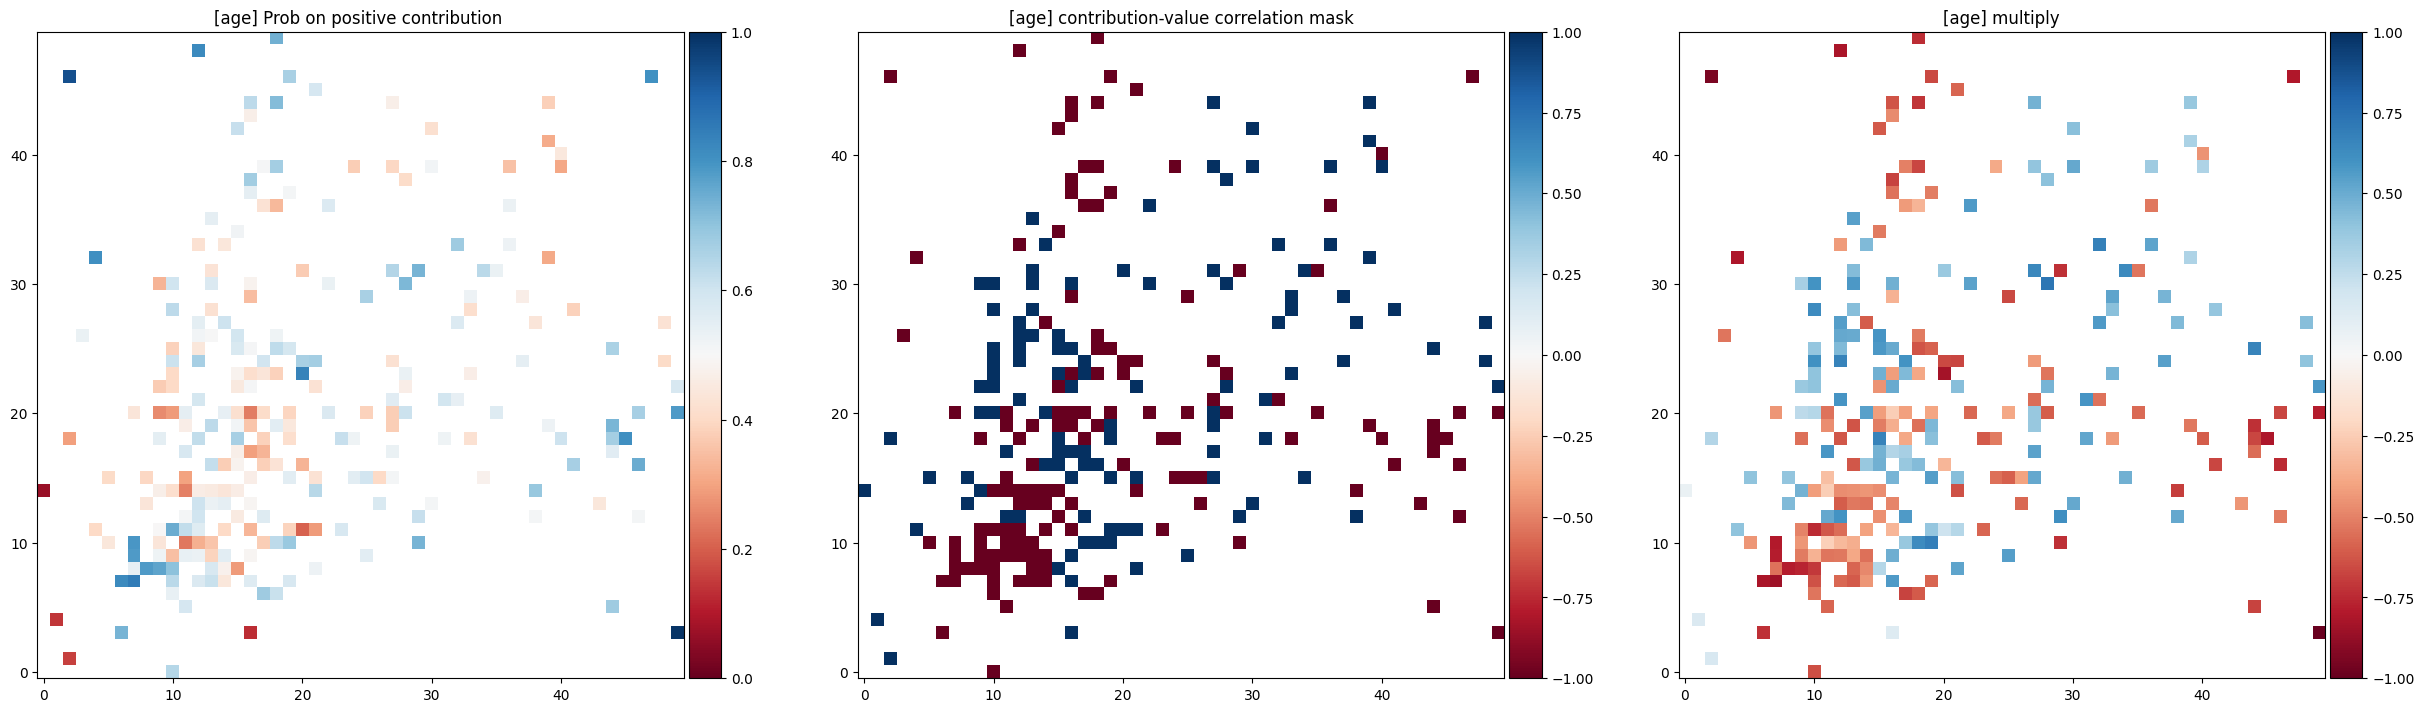

In [61]:
fig, ax = plt.subplots(1,3, figsize=(30, 30))

A = full_inp
B = full_shap
all_corr = np.array([np.corrcoef(A[:, i], B[:, i])[0,1] for i in range(2500)])

mask = np.sign(all_corr.reshape(50,50))

im = ax[0].imshow(new_probs, cmap="RdBu", vmin=0, vmax=1)
ax[0].invert_yaxis()
ax[0].set_title(f'[age] Prob on positive contribution ')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = ax[1].imshow(mask, cmap="RdBu", vmin=-1, vmax=1)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax[1].invert_yaxis()
ax[1].set_title(f'[age] contribution-value correlation mask')

im = ax[2].imshow(new_probs * mask, cmap="RdBu", vmin=-1, vmax=1)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax[2].invert_yaxis()
ax[2].set_title(f'[age] multiply')

# Simplistic model

In [13]:
# This full test is used from cross validation
_smp_feat_selection = ['iqr_iti', 'median_iti', 'median_taps']

Xdf = X[_smp_feat_selection].astype('float32')
Ydf = X['age'].astype('float32')

dM = xgb.DMatrix(data=Xdf, label=Ydf)

_X = dM.get_data()
_y = dM.get_label()

print(_X.shape, _y.shape)

(5093, 3) (5093,)


In [14]:
params = {'objective':'reg:squarederror', 
          'tree_method': 'gpu_hist',
          'learning_rate': 0.1, 
          'max_depth': 4
          }

xgb_cv = cv(dtrain=dM, params=params, nfold = len(folds), folds=folds,
                    num_boost_round=5000, early_stopping_rounds=5, metrics=["mae", "rmse"], as_pandas=True)
n_estimators = len(xgb_cv)
xgb_cv.tail(5)

,train-mae-mean,train-mae-std,train-rmse-mean,train-rmse-std,test-mae-mean,test-mae-std,test-rmse-mean,test-rmse-std
45,9.514698,0.123820,12.193187,0.108019,10.625799,0.870570,13.532957,1.008441
46,9.496536,0.121945,12.178546,0.105912,10.619413,0.872346,13.531636,1.009432
47,9.480194,0.123086,12.168898,0.106761,10.611789,0.874551,13.528585,1.009413
48,9.467061,0.122680,12.159943,0.105124,10.604212,0.874816,13.527313,1.008180
49,9.448170,0.122760,12.144495,0.106586,10.594887,0.877572,13.521851,1.009469


In [15]:
estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params)

cv_pred = cross_val_predict(estimator, X=_X, y=_y, cv=folds)

_rmse = pd.DataFrame(mean_squared_error(_y, cv_pred, squared=False, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_r2 = pd.DataFrame(r2_score(_y, cv_pred, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))
_mae = pd.DataFrame(mean_absolute_error(_y, cv_pred, multioutput='raw_values').reshape(1,len(Ydf.shape)), columns=[Ydf.name] if len(Ydf.shape) == 1 else list(Ydf.columns))

_res= pd.concat([_rmse, _r2, _mae])
_res.index = ['rmse', 'r2-score', 'mae']
_res

,age
rmse,13.625139
r2-score,0.359995
mae,10.626155


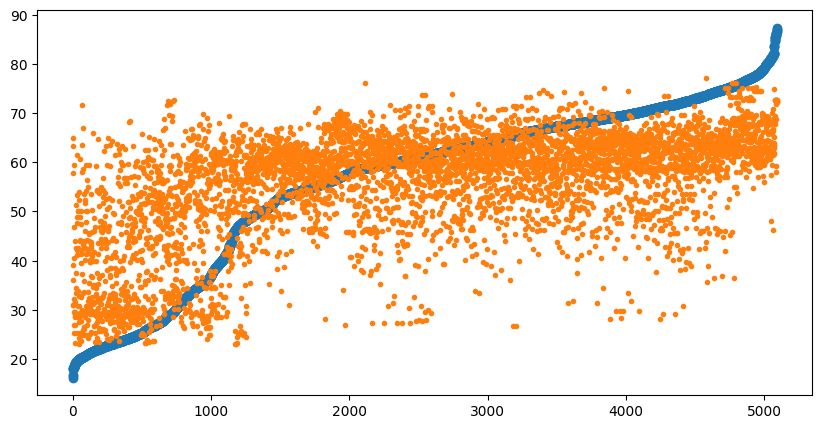

In [16]:
plt.figure(figsize=(10, 5))
_idx = np.argsort(_y)
plt.plot(_y[_idx], 'o')
plt.plot(cv_pred[_idx], '.')

# Save the parameters
Technically these hypterparameters might not be ideal for all JID integration times, but we assume they are OK and we will train the models with shorter integration times (1, 2, 3, 7 days) with these parameters. If time permits one can optimize these parameters on shorter windows by using the same code.

In [ ]:
estimators = []

for i, (tr, te) in enumerate(folds):
    estimator = xgb.XGBRegressor(n_estimators=len(xgb_cv_post), **params)
    estimator.fit(_X[tr], _y[tr])
    print(estimator.score(_X[te], _y[te]))
    estimators.append(estimator)
    estimator.save_model(f'./models/model_full_age_{window}_days_{version}_fold{i}.json')

# Trajectories

In [66]:
# given a person I need to pick the model for which they were in the test fold 
def find_fold_for_partId(partId, P):
    try:
        _idx = np.where(P == partId)[0][0]
        k = np.where([_idx in a for _, a in folds])[0][0]
        return k
    except:
        return -1

In [67]:
def find_longest_uninterrupted(times):

    if len(times.shape) == 0:
        return None
    
    beg_int = np.where(np.diff(np.float32(times < 1)) == 1)[0] + 1
    end_int = np.where(np.diff(np.float32(times < 1)) == -1)[0] + 1
    if len(beg_int) == len(end_int) + 1:
        end_int = np.array(list(end_int) + [len(m_)])
    _int_len = [ e - b for b, e in zip(beg_int, end_int) if e - b > 7]
    #     print(_int_len)
    _int = [(b, e) for b, e in zip(beg_int, end_int) if e - b > 7]
    non_int = [0] + list(itertools.chain.from_iterable(_int)) + [len(times) - 1]
    _non_int = [(a, b) for a, b in zip(non_int[::2], non_int[1::2])]
    _non_int_len = [a[1] - a[0] for a in _non_int]
    #     print(_non_int_len)
    longest = np.argmax(_non_int_len)

    if np.max(_non_int_len) >= 365:
        return _non_int[longest]
    else:
        return None

In [ ]:
all_lens = []
for i, name in notebook.tqdm(enumerate(os.listdir(f"./evol_v11/21d/"))):
    data = loadmat(f"./evol_v11/21d/{name}")
    X_ = np.squeeze(data['x']).T.reshape(-1, 2500)
    all_lens.append(X_.shape[0])

In [ ]:
all_ages = []
all_genders = []
all_entropy = []
the_gap = []
all_preds = []
all_preds_times = []
all_pids = []
was_testing = []
all_tests_with_times = []
for i, name in notebook.tqdm(enumerate(os.listdir(f"./evol_v11/21d/"))):
    data = loadmat(f"./evol_v11/21d/{name}")
    X_ = np.squeeze(data['x']).T.reshape(-1, 2500)
    a_ = np.squeeze(data['all_ages'])
    g_ = np.squeeze(data['gender'])
    u_ = np.squeeze(data['all_usage'])
    m_ = np.squeeze(data['all_median_tap_speed'])
    i_ = np.squeeze(data['all_iqr_tap_speed'])
    t_ = np.squeeze(data['all_ts'])
    nd_ = np.squeeze(data['all_n_days'])
    pid = data['partId'][0]
    
    _fold = find_fold_for_partId(pid, partIds)
    if (_fold == -1):
        continue
    
    idxs = find_longest_uninterrupted(m_)
    if idxs is None:
        continue
    
    # create the X, Y matrices for model training
    X_ = np.concatenate([np.log10(X_ + 3.1463e-12),
                        a_[:, None],
                        np.log10(i_[:, None] + 3.1463e-12),
                        np.log10(m_[:, None] + 3.1463e-12),
                        np.log10(u_[:, None] + 3.1463e-12)
                        ], axis=1)
    
    feat_names = [f"{i // 50}-{i % 50}" for i in range(2500) ] + ['age', 'iqr_iti', 'median_iti', 'median_taps']
    
    X_ = pd.DataFrame(X_[idxs[0]:idxs[1] + 1, :], columns=feat_names)
    
    nbins = 50
    _feat_selection = [f"{i // nbins}-{i % nbins}" for (i, v) in enumerate(param_dict['support'][:-4]) if v ] + ['iqr_iti', 'median_iti', 'median_taps']
    
    _x = X_[_feat_selection].astype('float32')
    _y = X_['age'].astype('float32')
    
    model_full = xgb.XGBRegressor()
    model_full.load_model(f'./models/model_full_age_21_days_v11_fold{_fold}.json')
    
    pred_over_time = model_full.predict(_x)
    
    all_preds_times.append(t_[idxs[0]:idxs[1] + 1])
    all_preds.append(pred_over_time)
    
    all_ages.append(a_[idxs[0]:idxs[1] + 1])
    all_genders.append(float(g_))
    all_pids.append(pid)

In [ ]:
len(all_preds)

In [ ]:
IDX = 126
plt.plot(pd.to_datetime(all_preds_times[IDX], unit='ms'), all_preds[IDX])
plt.plot(pd.to_datetime(all_preds_times[IDX], unit='ms'), all_ages[IDX])

In [ ]:
extra_people = np.squeeze(loadmat('extra_pids.mat')['extra_pids'])
extra_people[0][0]

In [68]:
all_ages = []
all_genders = []
all_entropy = []
the_gap = []
all_preds = []
all_preds_times = []
all_pids = []
was_testing = []
all_tests_with_times = []

model_full = load('./models/model_full_age_21_days_v11.joblib')
for i, name in notebook.tqdm(enumerate(extra_people)):
    try:
        data = loadmat(f"./evol_v11/21d/{name[0]}")
    
        X_ = np.squeeze(data['x']).T.reshape(-1, 2500)
        a_ = np.squeeze(data['all_ages'])
        g_ = np.squeeze(data['gender'])
        u_ = np.squeeze(data['all_usage'])
        m_ = np.squeeze(data['all_median_tap_speed'])
        i_ = np.squeeze(data['all_iqr_tap_speed'])
        t_ = np.squeeze(data['all_ts'])
        nd_ = np.squeeze(data['all_n_days'])
        pid = data['partId'][0]
        
        _fold = find_fold_for_partId(pid, partIds)
        print(_fold)
        if (_fold == -1):
            _fold = 0

        # create the X, Y matrices for model training
        X_ = np.concatenate([np.log10(X_ + 3.1463e-12),
                            a_[:, None],
                            np.log10(i_[:, None] + 3.1463e-12),
                            np.log10(m_[:, None] + 3.1463e-12),
                            np.log10(u_[:, None] + 3.1463e-12)
                            ], axis=1)
        
        feat_names = [f"{i // 50}-{i % 50}" for i in range(2500) ] + ['age', 'iqr_iti', 'median_iti', 'median_taps']
        
        X_ = pd.DataFrame(X_, columns=feat_names)
        
        nbins = 50
        _feat_selection = [f"{i // nbins}-{i % nbins}" for (i, v) in enumerate(param_dict['support'][:-4]) if v ] + ['iqr_iti', 'median_iti', 'median_taps']
        
        _x = X_[_feat_selection].astype('float32')
        _y = X_['age'].astype('float32')
        
        model_full = xgb.XGBRegressor()
        model_full.load_model(f'./models/model_full_age_21_days_v11_fold{_fold}.json')
        
        pred_over_time = model_full.predict(_x)
        
        all_preds_times.append(t_)
        all_preds.append(pred_over_time)
        
        all_ages.append(a_)
        all_genders.append(float(g_))
        all_pids.append(pid)
    except:
        print(f"{name[0]} not FOUND or could not process")
        continue

NameError: name 'extra_people' is not defined

In [ ]:
len(all_ages)

In [ ]:
savemat('all_age_pred_21d_OLD_06_12_2023.mat', {
    'all_preds': np.asanyarray(all_preds, dtype=object), 
                                                  'all_preds_times': np.asanyarray(all_preds_times, dtype=object),
                                                  'all_ages': np.asanyarray(all_ages, dtype=object), 
                                                  'all_genders': np.asanyarray(all_genders, dtype=object), 
                                                  'all_pids': np.asanyarray(all_pids, dtype=object)
                                           })

In [ ]:
IDX = 116
plt.plot(all_preds_times[IDX], all_preds[IDX])
plt.plot(all_preds_times[IDX], all_ages[IDX])

In [ ]:
NORM = loadmat('all_age_pred_21d_30_11_2023.mat')
len(np.squeeze(NORM['all_preds']))

In [ ]:
IDX = 15
p = all_pids[IDX]
plt.plot(all_preds_times[IDX], all_preds[IDX])
plt.plot(all_preds_times[IDX], all_ages[IDX])
idx = np.where(np.squeeze(NORM['all_pids']) == p)[0][0]
plt.plot(np.squeeze(NORM['all_preds_times'])[idx][0], np.squeeze(NORM['all_preds'])[idx][0])

In [ ]:
np.squeeze(NORM['all_preds'])[idx][0]

# Shapley trajectories

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [87]:
all_ages = []
all_genders = []
all_entropy = []
the_gap = []
all_preds = []
all_preds_times = []
all_pids = []
was_testing = []
all_tests_with_times = []
all_shaps = []
all_inp = []

for i, name in notebook.tqdm(enumerate(os.listdir(f"./evol_v11/21d/"))):
    # try:
        data = loadmat(f"./evol_v11/21d/{name}")
    
        X_ = np.squeeze(data['x']).T.reshape(-1, 2500)
        a_ = np.squeeze(data['all_ages'])
        g_ = np.squeeze(data['gender'])
        u_ = np.squeeze(data['all_usage'])
        m_ = np.squeeze(data['all_median_tap_speed'])
        i_ = np.squeeze(data['all_iqr_tap_speed'])
        t_ = np.squeeze(data['all_ts'])
        nd_ = np.squeeze(data['all_n_days'])
        pid = data['partId'][0]
        
        _fold = find_fold_for_partId(pid, partIds)
        if (_fold == -1):
            continue
        
        idxs = find_longest_uninterrupted(m_)
        if idxs is None:
            continue

        # create the X, Y matrices for model training
        X_ = np.concatenate([np.log10(X_ + 3.1463e-12),
                            a_[:, None],
                            np.log10(i_[:, None] + 3.1463e-12),
                            np.log10(m_[:, None] + 3.1463e-12),
                            np.log10(u_[:, None] + 3.1463e-12)
                            ], axis=1)
        
        feat_names = [f"{i // 50}-{i % 50}" for i in range(2500) ] + ['age', 'iqr_iti', 'median_iti', 'median_taps']
        
        X_ = pd.DataFrame(X_, columns=feat_names)
        
        nbins = 50
        _feat_selection = [f"{i // nbins}-{i % nbins}" for (i, v) in enumerate(param_dict['support'][:-4]) if v ] + ['iqr_iti', 'median_iti', 'median_taps']
        
        _x = X_[_feat_selection].astype('float32')
        _y = X_['age'].astype('float32')
        
        model_full = xgb.XGBRegressor()
        model_full.load_model(f'./models/model_full_age_21_days_v11_fold{_fold}.json')
        
        explainer = shap.TreeExplainer(model_full, model_output='raw') # use model_output = 1 for scale trees
        shap_values = explainer.shap_values(_x)
        all_shaps.append(shap_values)
        all_inp.append(_x)

        pred_over_time = model_full.predict(_x)
        
        all_preds_times.append(t_)
        all_preds.append(pred_over_time)
        
        all_ages.append(a_)
        all_genders.append(float(g_))
        all_pids.append(pid)

    # except:
        # print(f"{name[0]} not FOUND or could not process")
        # continue


0it [00:00, ?it/s]

In [92]:
all_inp[IDX]

,0-10,1-2,3-6,3-16,3-49,4-1,5-11,5-44,6-10,6-17,...,44-39,45-21,46-2,46-19,46-47,48-12,49-18,iqr_iti,median_iti,median_taps
0,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-1.651617,-11.5022,-1.651617,-1.651617,...,-1.350587,-1.174496,-11.5022,-1.350587,-11.502200,-11.5022,-11.5022,3.594006,3.339054,2.624282
1,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-1.662167,-11.5022,-1.662167,-1.662167,...,-1.361137,-1.185046,-11.5022,-1.361137,-11.502200,-11.5022,-11.5022,3.586475,3.330109,2.621176
2,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-1.668742,-11.5022,-1.668742,-1.668742,...,-1.191620,-1.367712,-11.5022,-1.367712,-11.502200,-11.5022,-11.5022,3.583114,3.329194,2.618048
3,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-1.689370,-11.5022,-1.689370,-1.689370,...,-1.212249,-1.388340,-11.5022,-1.388340,-11.502200,-11.5022,-11.5022,3.580012,3.327257,2.647383
4,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-1.710930,-11.5022,-1.710930,-1.710930,...,-1.233809,-1.409900,-11.5022,-1.710930,-11.502200,-11.5022,-11.5022,3.581267,3.326643,2.670246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-11.502200,-11.5022,-11.502200,-11.502200,...,-1.546865,-11.502200,-11.5022,-11.502200,-1.546865,-11.5022,-11.5022,3.690196,3.383007,2.930949
1050,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-11.502200,-11.5022,-11.502200,-11.502200,...,-1.282983,-11.502200,-11.5022,-11.502200,-1.584013,-11.5022,-11.5022,3.693243,3.383546,2.879669
1051,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-11.502200,-11.5022,-11.502200,-11.502200,...,-1.268663,-11.502200,-11.5022,-11.502200,-1.569693,-11.5022,-11.5022,3.691524,3.386321,2.850646
1052,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-11.5022,-11.502200,-11.5022,-11.502200,-11.502200,...,-1.544441,-11.502200,-11.5022,-11.502200,-1.544441,-11.5022,-11.5022,3.682957,3.373372,2.805161


In [120]:
all_pids

['138ee7b17c315ed64a2c9e310c6424e54e4028eb',
 '138ebcb331b46e7b4d28bf7ece222b01f60928eb',
 '138eb77b96a2179e45948f8886fd8a39827b28eb',
 '138ee527c7bf08004a379f44a91a0987c93428eb',
 '138ea24f7a201c594b2c84868a4415b44f8d28eb',
 '138ed2f667d2fba247fea75953bc219c14d728eb',
 '138ea3cd0c72b1f5489c8c21a035df91640e28eb',
 '138ec05053313aa240df82e89c2ba3479c4328eb',
 '138ec064adae24544491a72797f143e0211a28eb',
 '138e9ca8033047e4490bb3f39105bdf7360f28eb',
 '138ecf662483e6d343c48d54cabc650243b528eb',
 '138eaa3708fb2d9f4d55b8fe7a28a3c4b40f28eb',
 '138e68e72709225e426ebd0cc6d91e72be5428eb',
 '138e66eb479ec8ac497b8d3055ed7054535628eb',
 '138e98dac4f8d10d424a94fd34de1c19df6228eb',
 '138e67cf4bc5646243818407550a0f492a8228eb',
 '138ec47994a2a2a945efb63400e9cb3050ff28eb',
 '138ec9874422c48b4002b7575a0d330099df28eb',
 '138e982e7595b1de4e3b9c928629548e98a528eb',
 '138ef57d88e7b2014e32880357acb08b763e28eb',
 '138e665cdb5a7616402db1c8bc50a49b29f628eb',
 '138ee344fd0ebd1b4437a613b0da06bd54e128eb',
 '138eff3d

In [119]:
np.where(all_pids =='138ec05053313aa240df82e89c2ba3479c4328eb')

(array([], dtype=int64),)

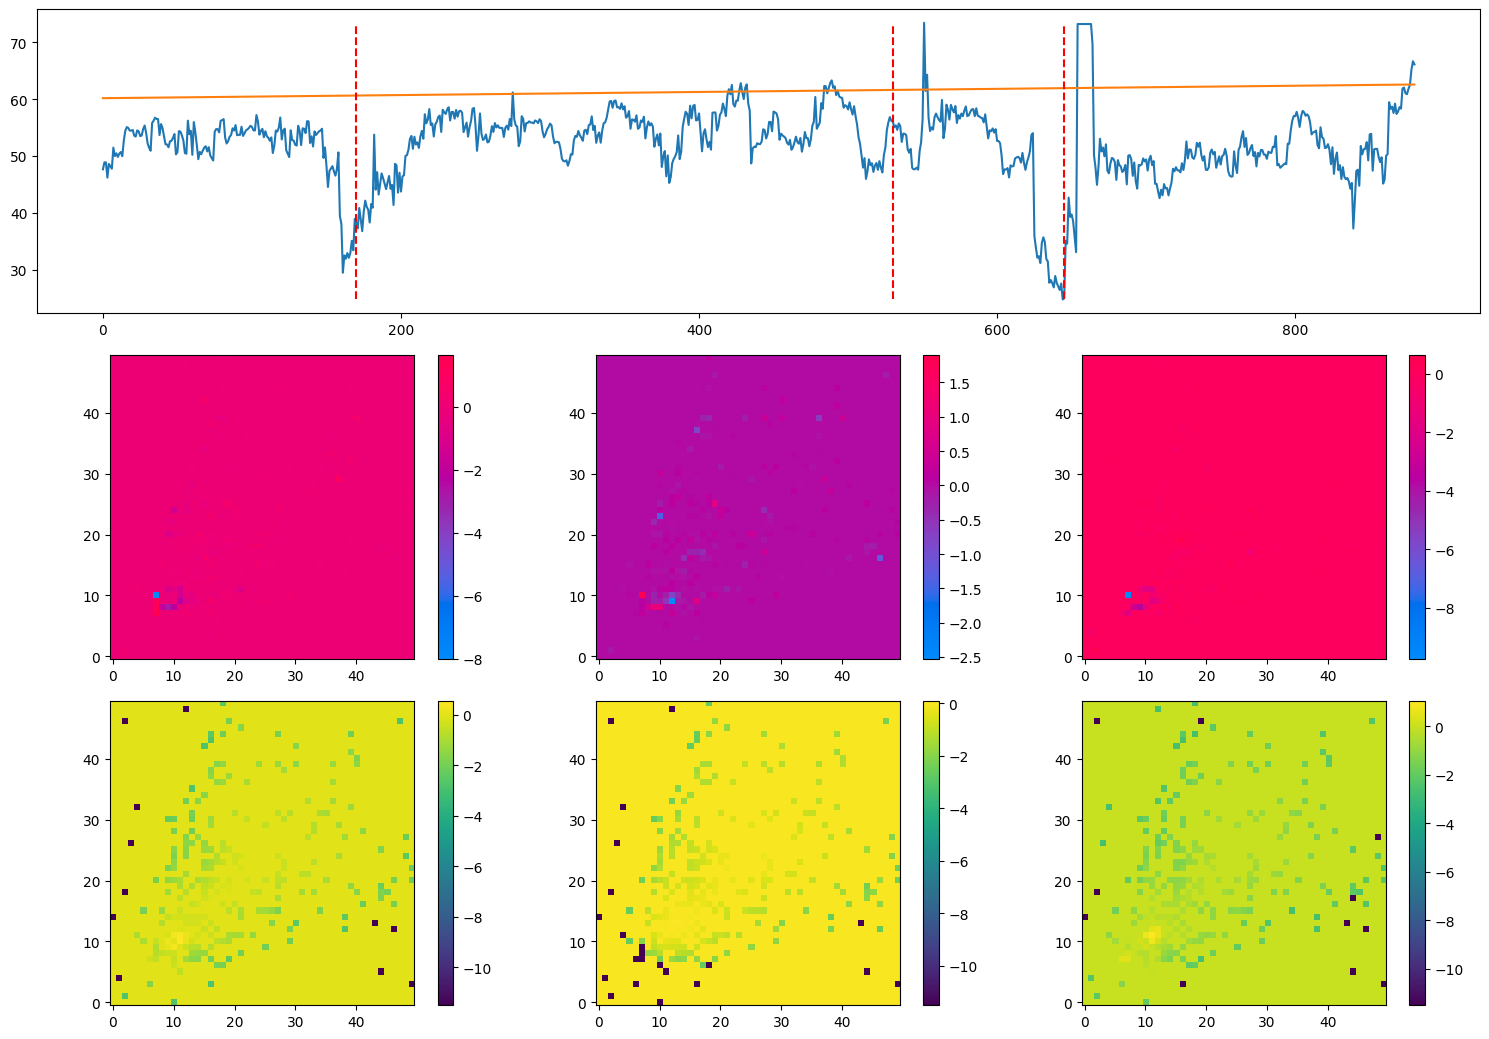

In [117]:
IDX = 14
idxs = [170, 530, 645]
fig = plt.figure(figsize=(15, 10.5), tight_layout=True)
gs = gridspec.GridSpec(3, len(idxs))

# taps
axt = fig.add_subplot(gs[0, :])
axt.plot(all_preds[IDX])
axt.plot(all_ages[IDX])
for i,_idx in enumerate(idxs) :
    axt.plot([_idx, _idx], [np.min(all_preds[IDX]), np.max(all_preds[IDX])], '--r')
    
    # taps
    jd1 = fig.add_subplot(gs[1, i])
    jd1b = fig.add_subplot(gs[2, i])
    full_shap = np.zeros(2500)
    full_shap[param_dict['support'][:2500]] = all_shaps[IDX][_idx, :247]
    full_inp = np.zeros(2500)
    full_inp[param_dict['support'][:2500]] = all_inp[IDX].values[_idx, :247]
    
    im = jd1.imshow(full_shap.reshape(50, 50), cmap=colors.red_blue)
    jd1.invert_yaxis()
    plt.colorbar(im, ax=jd1)
    
    im = jd1b.imshow(full_inp.reshape(50, 50))
    jd1b.invert_yaxis()
    plt.colorbar(im, ax=jd1b)

# jid
# jd2 = fig.add_subplot(gs[1, 1])
# jd2b = fig.add_subplot(gs[2, 1])
# full_shap = np.zeros(2500)
# full_shap[param_dict['support'][:2500]] = all_shaps[IDX][idxs[1], :247]
# full_inp = np.zeros(2500)
# full_inp[param_dict['support'][:2500]] = all_inp[IDX].values[idxs[1], :247]

# im = jd2.imshow(full_shap.reshape(50, 50), cmap=colors.red_blue)
# jd2.invert_yaxis()
# plt.colorbar(im, ax=jd2)

# im = jd2b.imshow(full_inp.reshape(50, 50))
# jd2b.invert_yaxis()
# plt.colorbar(im, ax=jd2b)

# # jid
# jd3 = fig.add_subplot(gs[1, 2])
# jd3b = fig.add_subplot(gs[2, 2])
# full_shap = np.zeros(2500)
# full_shap[param_dict['support'][:2500]] = all_shaps[IDX][idxs[2], :247]
# full_inp = np.zeros(2500)
# full_inp[param_dict['support'][:2500]] = all_inp[IDX].values[idxs[2], :247]

# im = jd3.imshow(full_shap.reshape(50, 50), cmap=colors.red_blue)
# jd3.invert_yaxis()
# plt.colorbar(im, ax=jd3)

# im = jd3b.imshow(full_inp.reshape(50, 50))
# jd3b.invert_yaxis()
# plt.colorbar(im, ax=jd3b)